In [1]:
import ast
import json

from typing import Dict, Union

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.feature_selection import VarianceThreshold

# Импорт утилитарных функций для работы с данными: 
# проверка пропусков и открытие JSON файлов.
from data_utils import check_missing, open_json

sns.set()

pd.set_option('display.float_format', '{:.2f}'.format)
eng_format = ticker.EngFormatter()

# Описание задачи

**Цель проекта:** Спарсить данные о фильмах с сайта Кинопоиск и провести их анализ для последующего обучения модели машинного обучения, которая будет предсказывать сборы фильма в США.

**Цель текущего ноутбука:** 
<br>Провести исследовательский анализ данных (EDA) для извлеченных из предыдущего ноутбука фильмов, студий и участников кинопроектов. 
<br>Определить основные характеристики датасета, выявить возможные аномалии или проблемы в данных, а также подготовить данные для последующего моделирования.

**Основные этапы EDA:**

**1. Первичный осмотр данных:**
   - Оценка размера датасета, типов переменных и первичного содержания.

**2. Анализ пропущенных значений:**
   - Определение количества и доли пропущенных значений по каждой переменной.

**3. Визуальный анализ переменных:**
   - Построение графиков для ключевых переменных, анализ распределений и взаимосвязей.

**4. Очистка данных и инжиниринг признаков (если необходимо):**
   - Коррекция аномалий, создание новых переменных на основе имеющихся данных.

# Импорт данных

In [2]:
df = pd.read_csv('data/movies_main.csv', sep=';')

cols_to_drop = [
    'художники', 'актеры дубляжа', 'монтажеры', 'продюсеры', 'операторы',
    'композиторы', 'художники_id', 'актеры дубляжа_id', 'монтажеры_id',
    'продюсеры_id', 'операторы_id', 'композиторы_id'
]

# Оставим из персон колонки режиссеров актеров и сценаристов (редакторов)
# Их будем использовать в следующем ноутбуке для составления метрик
df = df.drop(cols_to_drop, axis=1)
df = df.set_index('movie_id')

# Переименуем редакторов в сценаристов для ясности
df = df.rename(columns={
    'редакторы': 'сценаристы',
    'редакторы_id': 'сценаристы_id'
})

cols_lists = [
    'genres', 'countries', 'режиссеры_id', 'сценаристы_id', 'актеры_id',
    'режиссеры', 'сценаристы', 'актеры'
]

# Заменим пустые списки в колонках на проупски
for col in cols_lists:
    df.loc[df[col] == "[]", col] = np.nan

votes = ['votes_filmCritics', 'votes_await', 'votes_imdb', 'votes_kp']
ratings = ['rating_kp', 'rating_imdb', 'rating_filmCritics']

# Нулевые рейтинги и оценки означают их отсутсвие - заменим на пропуски
for col in votes + ratings:
    df.loc[df[col] == 0, col] = np.nan

# Студии фильмов
studios = pd.read_csv('data/studios.csv', sep=';')

# Оставим только студии производства и спецэффектов
mask = studios.type.isin(['Спецэффекты', 'Производство'])
studios = studios[mask].copy()

# Преобразуем данные для присоединения к таблице с фильмами
grouped = studios.groupby(['movie_id', 'movie_name',
                           'type']).agg(list).reset_index()
wide_format = grouped.pivot(index='movie_id', columns='type', values='title')

# Дополним датасет информацией о студиях
df = pd.concat([df, wide_format], axis=1)

Описание полей:

- **movie_id** - уникальный идентификатор фильма.
- **movie_name** - название фильма.
- **year** - год выпуска фильма.
- **votes_kp, votes_imdb** - количество оценок фильма на Кинопоиске и IMDB.
- **rating_kp, rating_imdb** - рейтинги фильма на Кинопоиске и IMDB.
- **votes_filmCritics** - количество оценок кинокритиков в мире
- **rating_filmCritics** - рейтинг кинокритиков в мире
- **votes_await** - количество ожидающих фильм на Кинопоиске
- **movieLength** - длина фильма
- **ageRating, ratingMpaa** - возрастные рейтинги фильма
- **type** - тип картины (фильм/мультфильм)
- **genres** - жанры фильма
- **countries** - страны фильма
- **режиссеры, сценаристы, актеры** - имена персон, учавствующих в фильме
- **режиссеры_id, сценаристы_id, актеры_id** - id персон, учавствующих в фильме
- **fees_world, fees_usa, fees_russia** - сборы фильма в мире, США, России
- **fees_world_currency и т.д.** - валюта сборов фильма
- **budget, budget_currency** - бюджет и валюта бюджета фильма
- **videos_trailers_number** - количество трейлеров
- **videos_teasers_number** - количество тизеров
- **Производство** - студии производства
- **Спецэффекты** - студии спецэффектов

In [3]:
# Первые 5 строк DataFrame - для наглядности транспонируем
df[:5].T

movie_id,535341,1143242,1318972,462682,251733
movie_name,1+1,Джентльмены,Гнев человеческий,Волк с Уолл-стрит,Аватар
year,2011,2019,2021,2013,2009
votes_kp,1678838.00,1524128.00,1154017.00,1125382.00,1014540.00
votes_imdb,895482.00,372380.00,197022.00,1471424.00,1359191.00
votes_filmCritics,130.00,277.00,256.00,289.00,335.00
votes_await,15.00,13642.00,23490.00,43024.00,38689.00
rating_kp,8.81,8.56,7.61,7.98,7.97
rating_imdb,8.50,7.80,7.10,8.20,7.90
rating_filmCritics,6.80,6.50,6.30,7.80,7.40
movieLength,112.00,113.00,119.00,180.00,162.00


In [4]:
df.shape

(5329, 33)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5329 entries, 535341 to 647
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   movie_name              5329 non-null   object 
 1   year                    5329 non-null   int64  
 2   votes_kp                5329 non-null   float64
 3   votes_imdb              5329 non-null   float64
 4   votes_filmCritics       5005 non-null   float64
 5   votes_await             3398 non-null   float64
 6   rating_kp               5329 non-null   float64
 7   rating_imdb             5329 non-null   float64
 8   rating_filmCritics      5004 non-null   float64
 9   movieLength             5329 non-null   float64
 10  ageRating               5010 non-null   float64
 11  ratingMpaa              4667 non-null   object 
 12  type                    5329 non-null   object 
 13  genres                  5329 non-null   object 
 14  countries               5329 non-null   o

- В DataFrame содержится 5329 записей и 25 столбцов.
- 16 столбцов имеют числовые значения (из них 13 с плавающей точкой и 3 целочисленные).
- 17 столбцов содержат текстовые (объектные) значения.
- Присутствуют пропуски

# Пропуски

In [6]:
check_missing(df)

,пропущенных_строк,процент_пропусков
режиссеры,3,0.06%
режиссеры_id,3,0.06%
актеры_id,4,0.08%
актеры,4,0.08%
videos_teasers_number,34,0.64%
videos_trailers_number,34,0.64%
сценаристы_id,39,0.73%
сценаристы,39,0.73%
Производство,66,1.24%
ageRating,319,5.99%


1. **Видеоматериалы**: 34 фильма (0.64%) без трейлеров или тизеров.


2. **Рейтинги**: 
   - `ageRating`: 319 фильмов (5.99%) без возрастного рейтинга.
   - `votes_filmCritics` и `rating_filmCritics`: Некоторые фильмы без оценок критиков.
   - `ratingMpaa`: 662 фильма (12.42%) без рейтинга MPAA.


3. **Финансовая информация**:
   - `budget`: 1402 фильма (26.31%) без данных о бюджете.
   - `votes_await`: 1931 фильм (36.24%) без ожидающих.
   - `fees_russia`: 1971 фильм (36.99%) без сборов в России.
   
   
4. **Студии и участники фильма**:
   - `Спецэффекты`: Для 1181 фильма (22.16%) отсутствует информация о студиях спецэффектов.
   - `Производство`: Для 66 фильмов (1.24%) отсутствует информация о производящих студиях.
   - `сценаристы`: Для 39 фильмов (0.73%) нет данных о редакторах.
   - `режиссеры`: 3 фильма (0.06%) без указания режиссёра.
   - `актеры`: 4 фильма (0.08%) без информации о актерском составе.

# Целевая переменная

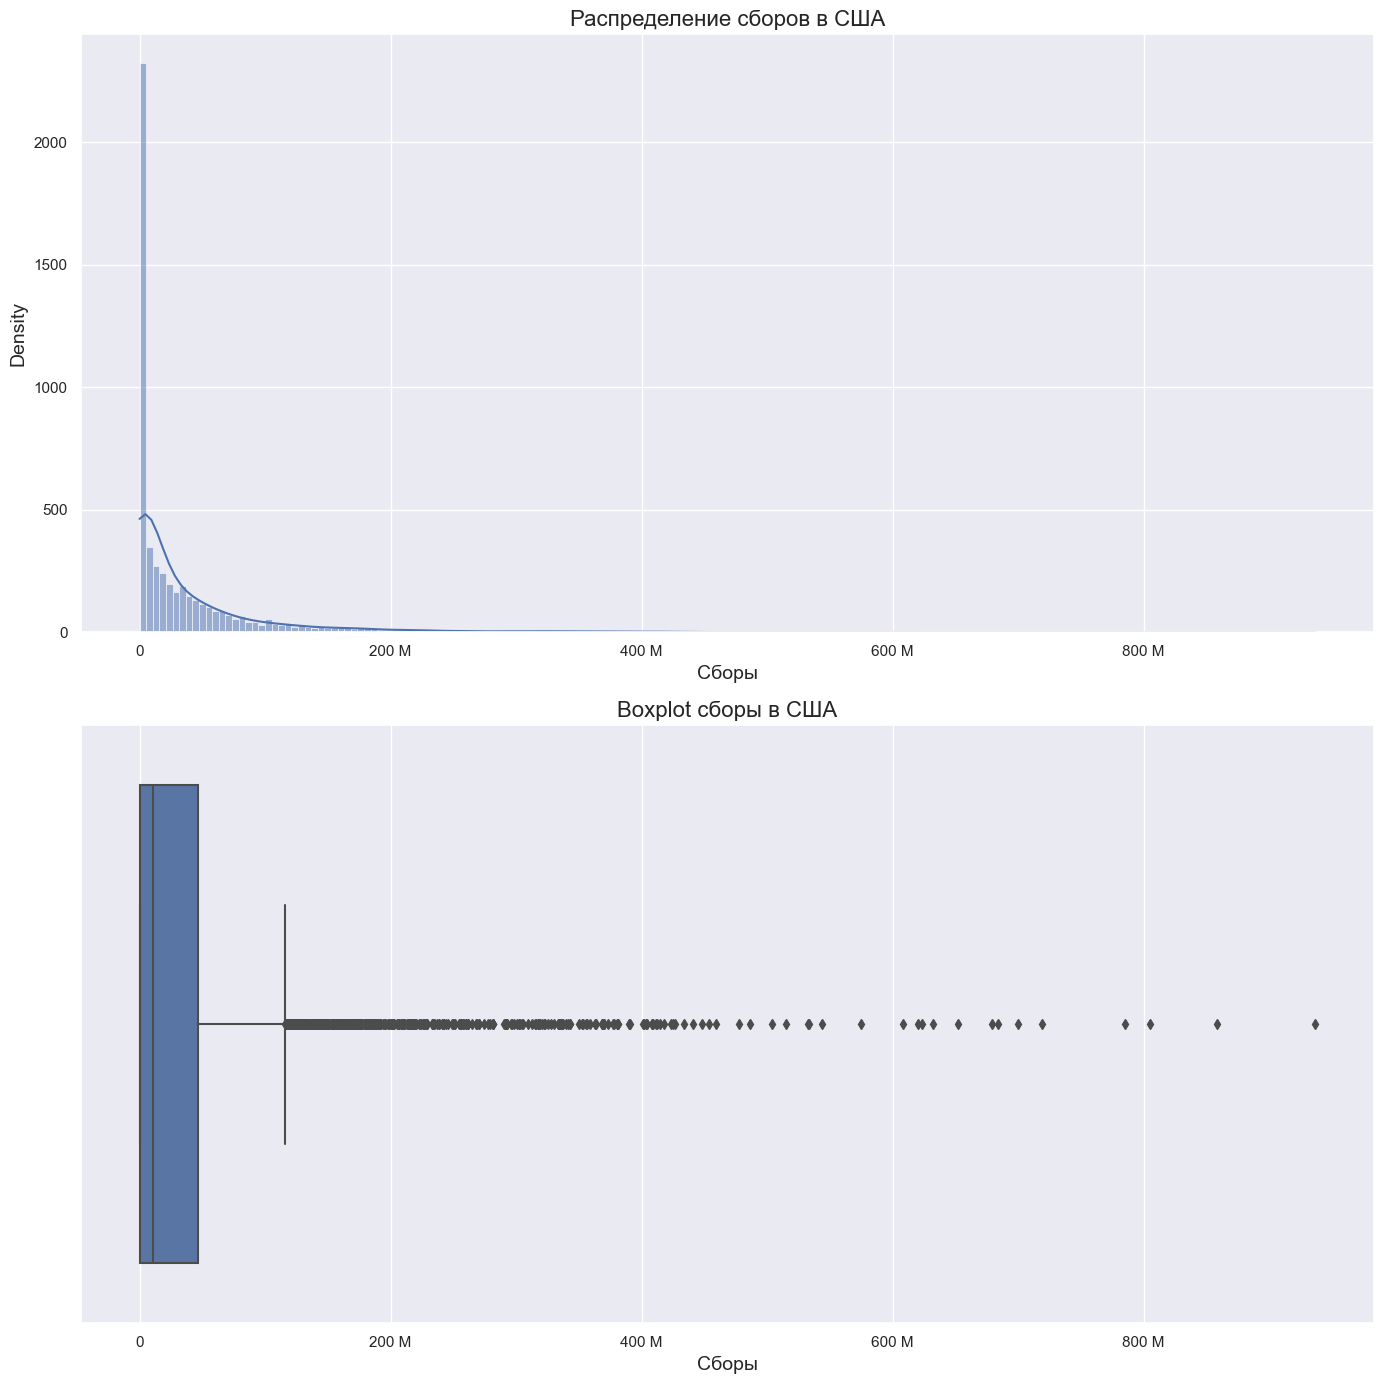

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# KDE Plot
# sns.kdeplot(df.fees_usa, ax=axes[0], fill=True)
sns.histplot(df.fees_usa, ax=axes[0], kde=True)

axes[0].set_title('Распределение сборов в США', fontsize=16)
axes[0].set_xlabel('Сборы', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)

# Boxplot
sns.boxplot(
    x=df.fees_usa,
    orient='h',
#     showfliers=False,
    ax=axes[1]
)
axes[1].set_title('Boxplot сборы в США', fontsize=16)
axes[1].set_xlabel('Сборы', fontsize=14)

# Форматтер для оси X
axes[0].xaxis.set_major_formatter(ticker.EngFormatter())
axes[1].xaxis.set_major_formatter(ticker.EngFormatter())

xlimits = axes[0].get_xlim()
axes[1].set_xlim(xlimits)

plt.tight_layout()
plt.show()

1. **Диапазон сборов:** Сборы фильмов варьируются от 0 до ~940 миллионов долларов.


2. **Медианные сборы:** Медианное значение сборов составляет ~10 миллионов долларов. Большая часть фильмов имеет сборы в пределах нескольких миллионов долларов
   
   
3. **Выбросы:** 
   - Существует около 500 фильмов, сборы которых превышают верхний предел выбросов. Эти фильмы можно рассматривать как блокбастеры или особо успешные проекты.
   - Отсутствие низких выбросов и наличие многих высоких выбросов указывает на то, что в индустрии кино очень высокий потенциал прибыли для определенных проектов.


4. **Общий вывод:** 

- Целевая переменная имеет длинный правый хвост. Распределение асимметричное. 
   <br>Есть много фильмов, имеющих относительно невысокие сборы, и небольшое количество фильмов с очень высокими сборами.

# Категориальные статистики

In [8]:
df.describe(include='object').T

,count,unique,top,freq
movie_name,5329,5206,Одержимость,4
ratingMpaa,4667,5,r,2399
type,5329,2,movie,5037
genres,5329,1299,['драма'],240
countries,5329,1008,['США'],2165
режиссеры,5326,2647,['Вуди Аллен'],19
сценаристы,5290,4635,['Вуди Аллен'],19
актеры,5325,5322,"['Джозефин Лэнгфорд', 'Хиро Файнс Тиффин', 'Лу...",2
режиссеры_id,5326,2648,[5890],19
сценаристы_id,5290,4640,[5890],19


2. **Рейтинг MPAA (`ratingMpaa`)**:
<br>Большинство фильмов (2399 из 4667) имеют рейтинг "R", что означает "Restricted" (ограничения для детей до 17 лет без сопровождения взрослого).


3. **Тип (`type`)**: Большая часть данных (5037 из 5329) относится к фильмам (не мультфильмам).


4. **Жанры (`genres`)**: Самый популярный жанр - "драма" (240 записей). Всего 1299 уникальных комбинаций жанров.


5. **Страны (`countries`)**: Большинство фильмов (2165 из 5329) произведены в США, но в данных есть 1008 уникальных комбинаций стран.


6. **Валюты**: 
   - `fees_world_currency`, `fees_usa_currency` и `fees_russia_currency` все указаны в долларах США.
   - Для бюджета фильма (`budget_currency`) есть 26 уникальных значений валюты, причем доллар США является самым распространенным, присутствующим в 3594 записях.
   
   
7. **Участники производства фильма**:
   - **Режиссеры**:  Наиболее часто встречающийся режиссер является Вуди Аллен, который режиссировал 19 фильмов. Всего 2647 уникальных записей режиссеров.
   - **Сценаристы**: Вуди Аллен также является наиболее часто встречающимся сценаристом, участвовав в редактировании 19 фильмов. Всего 4635 уникальных сочетаний редакторов.
   - **Актеры**: Актерский состав почти всегда уникален. Есть лишь один актерский состав, который повторяется 2 раза. Всего 5322 уникальных актерских состава.


8. **Студии (`Производство`)**:
   - Наиболее часто встречающейся студией в данных является "Pixar Animation Studios" с 20 фильмами. Всего присутствует 5066 уникальных записей производящих студий.


9. **Студии (`Спецэффекты`)**:
   - Наиболее часто встречающаяся компания - "Industrial Light & Magic (ILM)" с 81 фильмом. Эта компания известна своей работой над многими крупными блокбастерами. В датасете присутствуют 3231 уникальные записи компаний, занимающихся спецэффектами.

# Анализ валюты бюджета

In [9]:
# Посмотрим подробнее на уникальные значения валюты бюджета
df.budget_currency.value_counts()

budget_currency
$      3594
€       186
£        50
₹        21
CA$      11
NOK      11
A$        8
FRF       8
DKK       4
SEK       4
HUF       4
CN¥       4
₽         4
PLN       3
฿         2
HK$       2
₩         2
SGD       1
CZK       1
MX$       1
DEM       1
ATS       1
FIM       1
ESP       1
р.        1
R$        1
Name: count, dtype: int64

Большинство фильмов имеют бюджет, указанный в долларах США. Это делает доллар доминирующей валютой для киноиндустрии. Тем не менее, многие фильмы также имеют бюджеты в других валютах, отражая их страну происхождения или региональные особенности распределения.

In [10]:
# Посмотрим какие валюты, отличные от доллара присутствуют в разные годы
mask = df.budget_currency!='$'
df[mask].groupby(['budget_currency', 'year']).size().reset_index(name='count')

,budget_currency,year,count
0,A$,2000,1
1,A$,2008,1
2,A$,2009,1
3,A$,2010,1
4,A$,2011,3
...,...,...,...
107,₹,2016,1
108,₽,2014,1
109,₽,2016,1
110,₽,2017,1


**Конвертация валюты в USD**

Для анализа и последующего моделирования нам необходимо привести все значения бюджета к единой валюте. 
<br>Для этого используем средние курсы валют по годам и преобразуем бюджет фильма в доллары США. 

Данные о курсах валют были получены от ChatGPT и сохранены в формате JSON.

In [11]:
# Загружаем курсы валют из файла
exchange_rates = open_json('data_json/exchange_rates_from_GPT4.json')

# Вывод первых записей из файла с курсами валют
dict(list(exchange_rates.items())[:5])

{'A$_2000': 0.58,
 'A$_2008': 0.85,
 'A$_2009': 0.79,
 'A$_2010': 0.92,
 'A$_2011': 1.03}

## Перевод бюджета в доллары

In [12]:
# функция для конвертации валюты в USD
def convert_to_usd(row):
    key = f"{row['budget_currency']}_{row['year']}"
    if key in exchange_rates:
        return row['budget'] * exchange_rates[key]
    else:
        return None  # возвращаем None, если нет соответствующего курса валюты

# применяем функцию конвертации к каждой строке в DataFrame
df['budget_in_usd'] = df.apply(convert_to_usd, axis=1)

# Замена значений в колонке 'budget_in_usd' значениями из 'budget' 
# для фильмов с валютой доллара
mask = df.budget_currency == '$'
df.loc[mask, 'budget_in_usd'] = df.loc[mask, 'budget']

In [13]:
# Удалим колоноки с валютами, так как теперь в них одно уникальное значение - $
df = df.drop(['budget_currency', 
              'fees_usa_currency', 
              'fees_world_currency',
              'fees_russia_currency'
             ], axis=1)

# Числовые статистики

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,5329.00,2011.17,6.14,2000.00,2006.00,2011.00,2016.00,2023.00
votes_kp,5329.00,65567.76,113858.95,2000.00,6571.00,21733.00,72629.00,1678838.00
votes_imdb,5329.00,112577.18,183754.35,185.00,17471.00,47606.00,125348.00,2786027.00
votes_filmCritics,5005.00,143.87,90.42,5.00,79.00,132.00,191.00,761.00
votes_await,3398.00,7023.32,14078.26,1.00,306.00,1582.50,7010.75,225677.00
rating_kp,5329.00,6.68,0.83,1.59,6.18,6.75,7.24,8.84
rating_imdb,5329.00,6.42,0.94,1.30,5.90,6.50,7.10,9.00
rating_filmCritics,5004.00,5.92,1.39,1.80,4.90,6.00,7.00,9.40
movieLength,5329.00,108.07,18.55,41.00,95.00,105.00,118.00,224.00
ageRating,5010.00,15.11,3.72,0.00,16.00,16.00,18.00,18.00


1. **Годы выпуска фильмов**:
   - Фильмы в датасете представлены за период с 2000 по 2023 год.
   - Средний год выпуска фильма – 2011 год.
   
   
2. **Оценки**:
   - Медианные рейтинги: Кинопоиск – 6.75, IMDb – 6.50, кинокритики – 6.0. Оценки довольно высокие.
   
   
3. **Голоса**:
   - Медианное количество оценок: Кинопоиск – 21,733, IMDb – 47,606, кинокритики – 132.


4. **Длина фильма**:
   - Средняя длительность фильма – 108 минут, что соответствует стандартной продолжительности полнометражного фильма.
   - Фильмы в датасете имеют продолжительность от 41 минуты до 224 минут (почти 4 часа).
   
   
5. **Финансы**:
   - Медианные мировые сборы фильма составляют около 25,8 миллионов долларов, 
   - Мединанные сборы в США – 10,4 миллиона долларов.
   - Медианный бюджет фильма – 25 миллионов долларов.
   
   
6. **Видеоматериалы**:
   - В среднем, у фильма 2 трейлера. Максимальное количество трейлеров для одного фильма – 27.
   - Количество тизеров всегда равно 0.
   
   
7. **Возрастной рейтинг**:
   - Медианный возрастной рейтинг фильмов – 16 лет. Большинство фильмов предназначено для подростков и взрослых.

In [15]:
# Удалим колонку с количеством тизеров, так как она неинформативна
df = df.drop(['videos_teasers_number'], axis=1)

# Гипотеза (сборы и год выпуска + кол-во фильмов)

С течением лет, сборы фильмов в США увеличиваются, также увеличивается количество выпущенных фильмов.

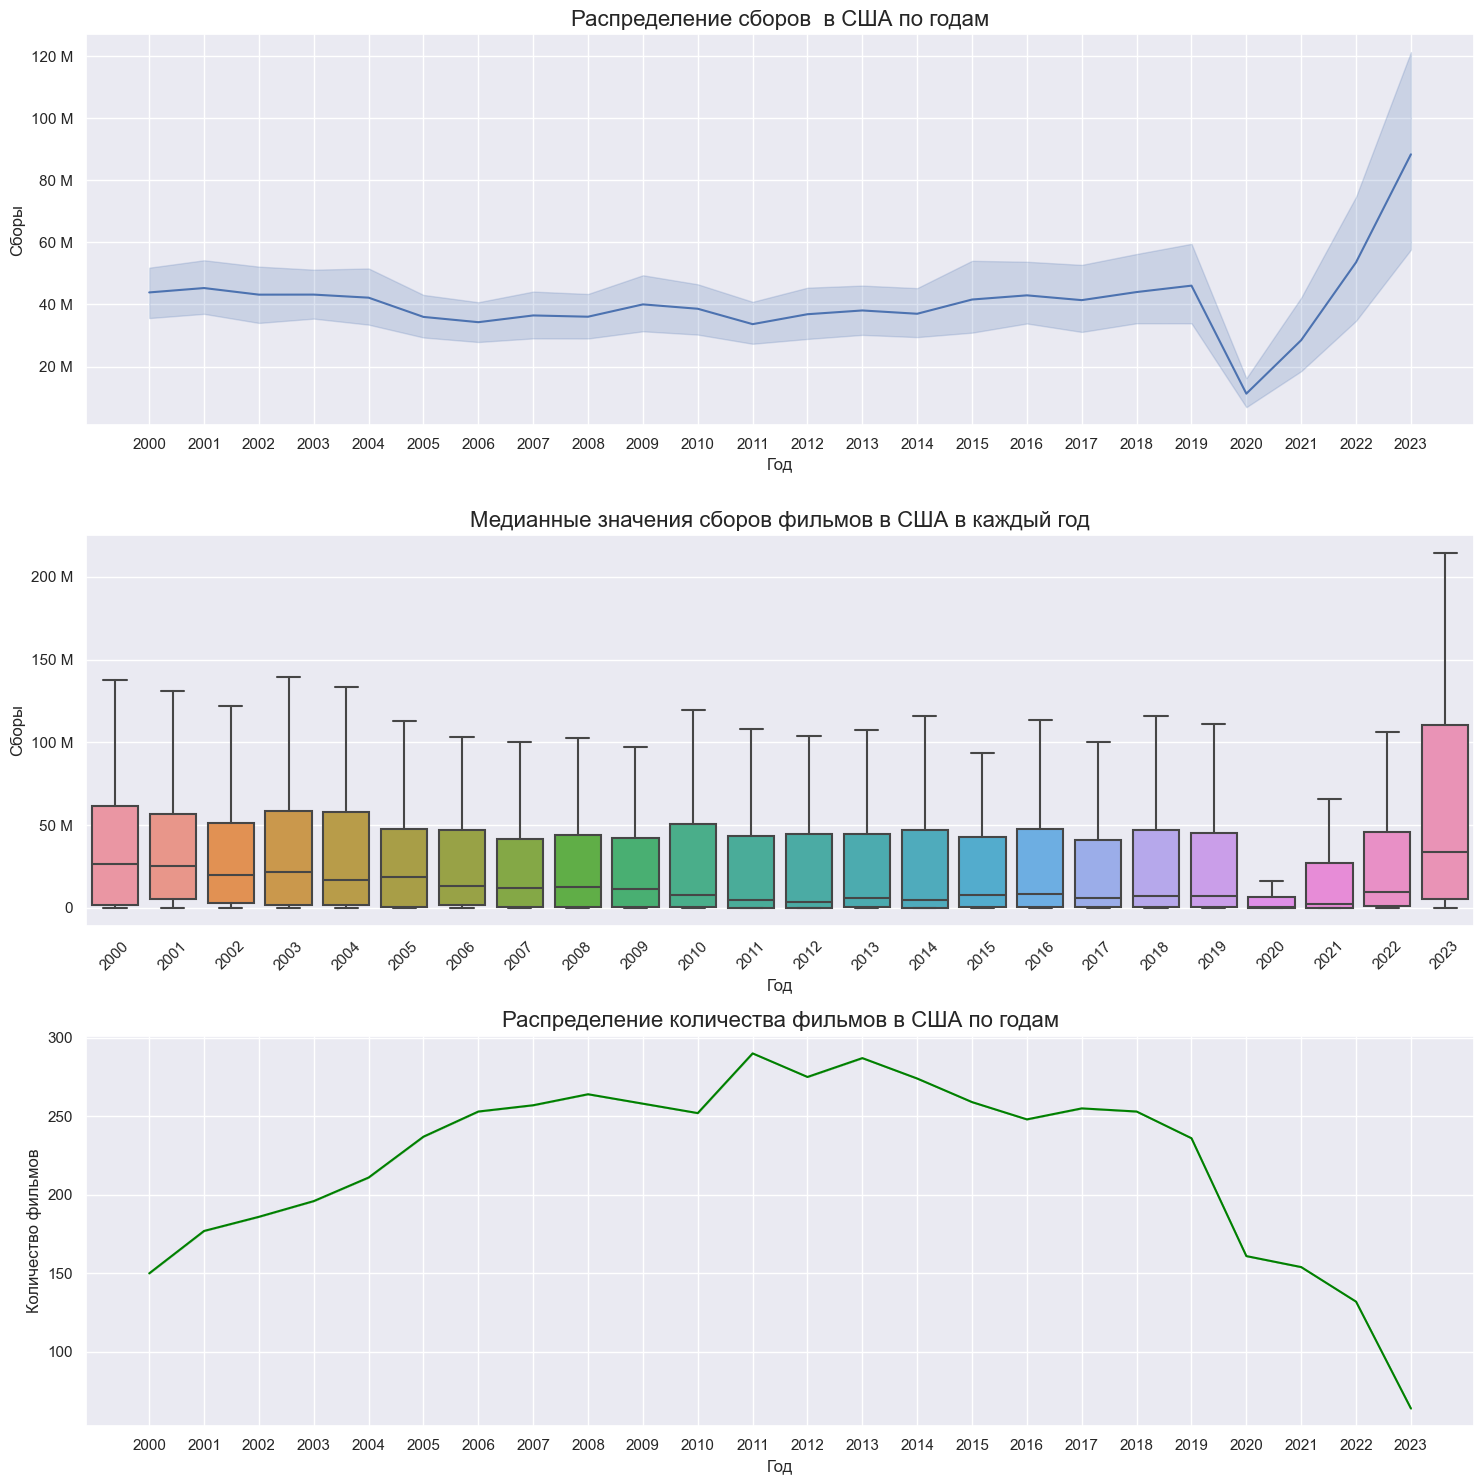

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))  # 3 графика
sns.set(font_scale=1.)  # увеличивает размер шрифта на 1.5 раза

sns.lineplot(data=df, x='year', y='fees_usa', ax=axs[0])
axs[0].set_title("Распределение сборов  в США по годам", fontsize=16)
axs[0].set_ylabel("Сборы")
axs[0].set_xlabel("Год")
eng_format = ticker.EngFormatter()
axs[0].yaxis.set_major_formatter(eng_format)
axs[0].set_xticks(list(range(2000, 2024, 1)))

sns.boxplot(data=df, x='year', y='fees_usa', showfliers=False, ax=axs[1])
axs[1].set_title(f"Медианные значения сборов фильмов в США в каждый год", fontsize=16)
axs[1].set_ylabel('Сборы')
axs[1].set_xlabel("Год")
axs[1].tick_params(axis='x', rotation=45)
axs[1].yaxis.set_major_formatter(eng_format)

df['movie_count'] = df.groupby('year').transform('size')
sns.lineplot(data=df, x='year', y='movie_count', ax=axs[2], color='green')
axs[2].set_title("Распределение количества фильмов в США по годам", fontsize=16)
axs[2].set_ylabel("Количество фильмов")
axs[2].set_xlabel("Год")
axs[2].yaxis.set_major_formatter(eng_format)
axs[2].set_xticks(list(range(2000, 2024, 1)))

del df['movie_count']

plt.tight_layout()
plt.show()

**Выводы:**

1. **Влияние пандемии:** 
<br>Резкое падение сборов в 2020 году, вероятно, связано с закрытием кинотеатров из-за пандемии и переносом премьер на онлайн-платформы.


2. **Восстановление после пандемии:** 
<br>После 2020 года наблюдается рост сборов. Это может быть связано с выпуском отложенных премьер, накопленным спросом зрителей и экономическим восстановлением.


3. **Динамика производства фильмов:** 
<br>Несмотря на значительное уменьшение количества фильмов в 2023 году, сборы некоторых блокбастеров достигли рекордных значений. Это подтверждает идею о том, что популярные фильмы по-прежнему привлекают внимание зрителей в кинотеатры.


4. **Цифровые релизы:** 
<br>Изменение потребительских предпочтений, усиленное пандемией, привело к росту популярности стриминговых платформ (Netflix, Amazon Prime Video, Disney+, HBO Max, Apple TV+ и т.д.), что может влиять на уменьшение количества фильмов в кинотеатрах.


5. **Эволюция кинотеатров:** 
<br>Несмотря на конкуренцию со стриминговыми платформами, кинотеатры ищут новые подходы к привлечению аудитории, предлагая высококачественные услуги и технологии.

# Гипотеза  (возрастной рейтинг и сборы)

Фильмы, предназначенные для более широкой аудитории (например, 6+, 12+ и 16+), имеют тенденцию привлекать больше зрителей и иметь более высокие сборы по сравнению с фильмами для взрослой аудитории (18+)."

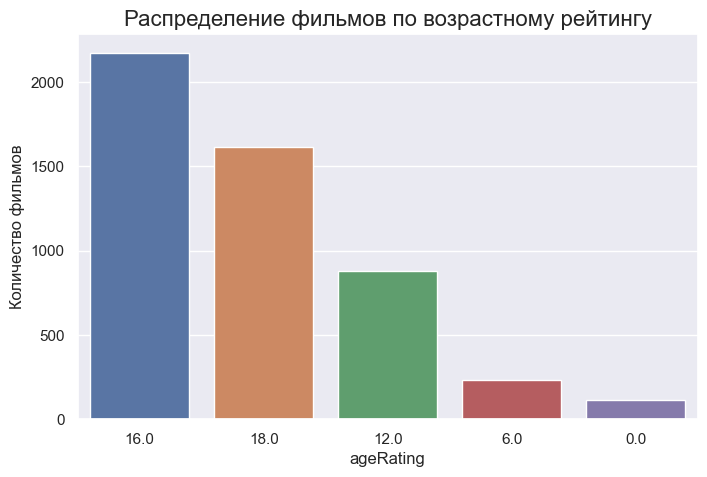

In [17]:
plt.figure(figsize=(8, 5))

type_counts = df['ageRating'].value_counts().reset_index()
type_counts.columns = ['ageRating', 'Количество фильмов']

# Построение гистограммы
sns.barplot(x='ageRating', y='Количество фильмов',
            data=type_counts, order=type_counts['ageRating'])

plt.title('Распределение фильмов по возрастному рейтингу', fontsize=16)

plt.show();

Фильмы с рейтингом 16+ наиболее распространены, в то время как фильмы с рейтингом 0+ наименее популярны. 

Это может говорить о том, что фильмы с рейтингом 16+ обычно целевые для более широкой аудитории, в то время как 0+ фильмы обычно предназначены для очень молодой аудитории и, следовательно, менее популярны.

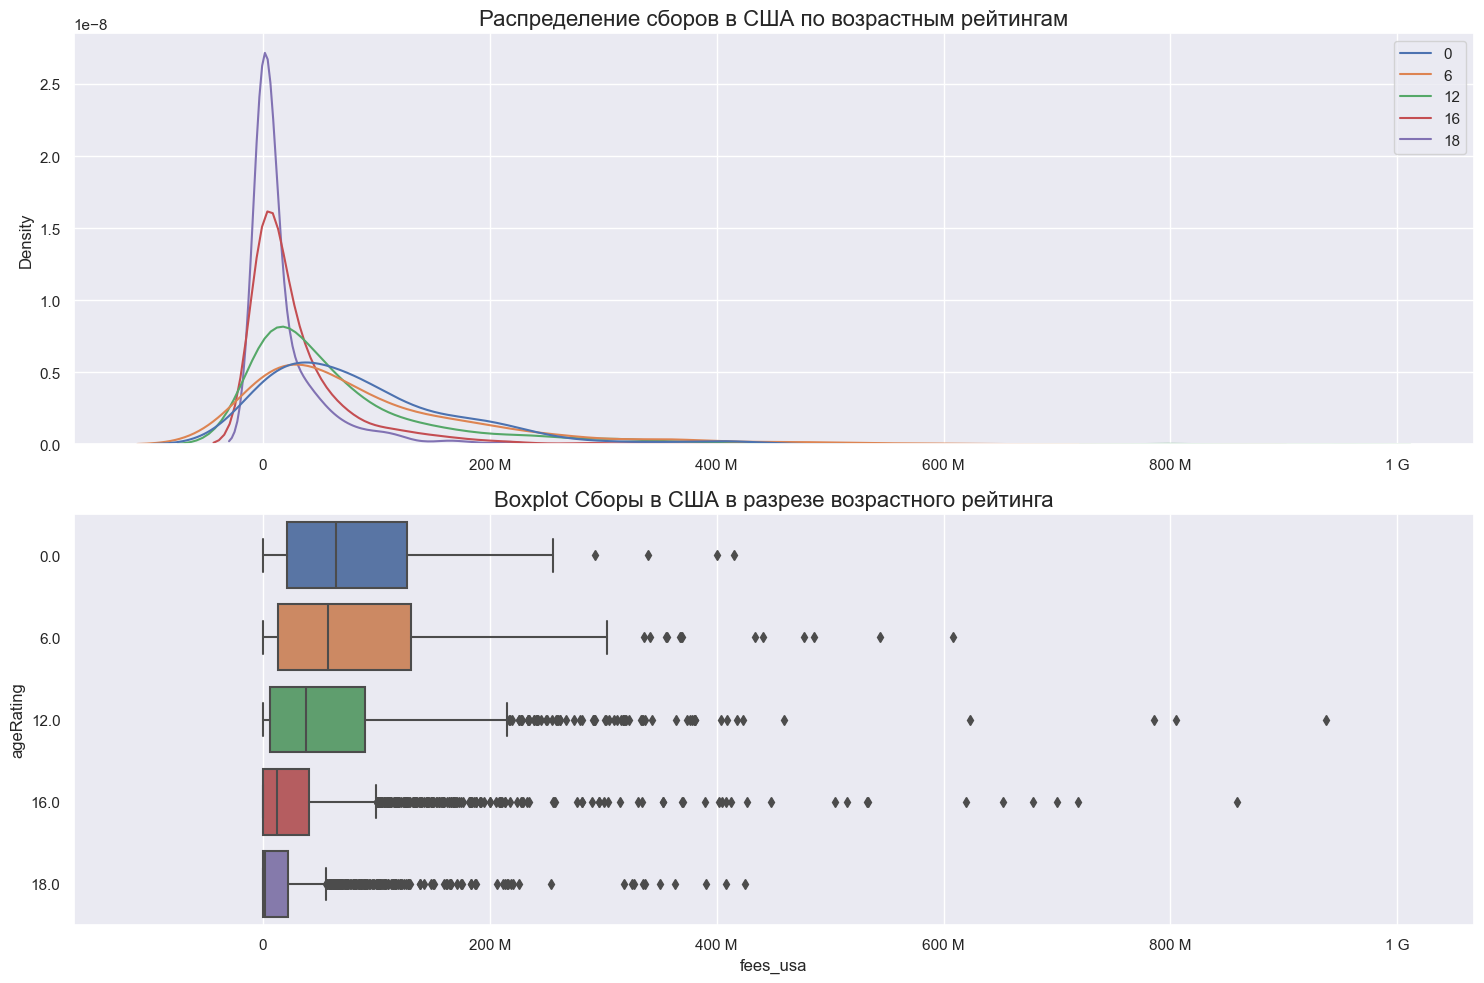

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# KDE plot
sns.kdeplot(data={
    "0": df[df.ageRating == 0].fees_usa,
    "6": df[df.ageRating == 6].fees_usa,
    "12": df[df.ageRating == 12].fees_usa,
    "16": df[df.ageRating == 16].fees_usa,
    "18": df[df.ageRating == 18].fees_usa,
},
            common_norm=False,
            ax=axes[0])

axes[0].xaxis.set_major_formatter(eng_format)
axes[0].set_title('Распределение сборов в США по возрастным рейтингам',
                  fontsize=16)

# Boxplot
sns.boxplot(data=df,
            y='ageRating',
            x='fees_usa',
            orient='h',
            showfliers=True,
            ax=axes[1])

axes[1].xaxis.set_major_formatter(eng_format)
axes[1].set_title('Boxplot Сборы в США в разрезе возрастного рейтинга',
                  fontsize=16)

xlimits = axes[0].get_xlim()
axes[1].set_xlim(xlimits)

plt.tight_layout()
plt.show()

**Выводы:**

1. **Максимальные сборы**: 
<br>Фильмы с рейтингом 6+ и 12+ имеют высшие максимальные сборы. Фильмы с такими рейтингами имеют потенциал стать блокбастерами.


2. **Медианные значения**: 
<br>Медианные сборы для фильмов с рейтингами 6+, 12+ и 16+ примерно сопоставимы и значительно выше, чем для 18+.


3. **Выбросы**: 
<br>Фильмы с рейтингами 12+, 16+ и 6+ имеют значительное количество высоких выбросов в сборах. 
<br>Значит некоторые фильмы в этих категориях имели огромный успех.


4. **Общие наблюдения**:
<br>Фильмы с рейтингом 18+ склонны иметь менее стабильные сборы и меньший потенциал для высоких доходов по сравнению с фильмами других рейтингов, хотя исключения, конечно, существуют.

# Гипотеза (сборы и тип картины)

Мультфильмы в среднем собирают больше денег в США, чем кинофильмы.

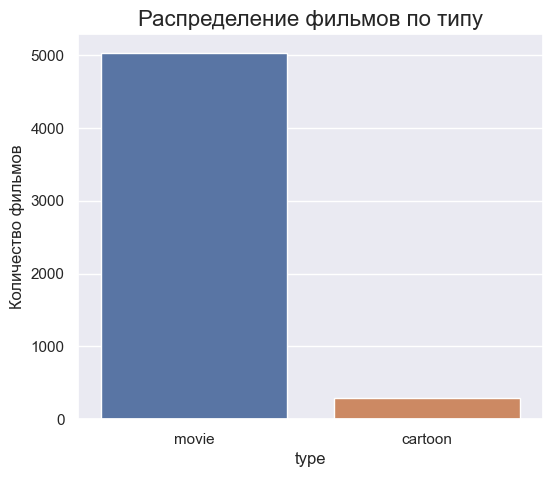

In [19]:
plt.figure(figsize=(6, 5))

type_counts = df['type'].value_counts().reset_index()
type_counts.columns = ['type', 'Количество фильмов']

# Построение гистограммы
sns.barplot(x='type', y='Количество фильмов',
            data=type_counts, order=type_counts['type'])

plt.title('Распределение фильмов по типу', fontsize=16)

plt.show();

Как и было видно из категориальных статистик, большая часть данных (5037 из 5329) относится к фильмам (не мультфильмам).

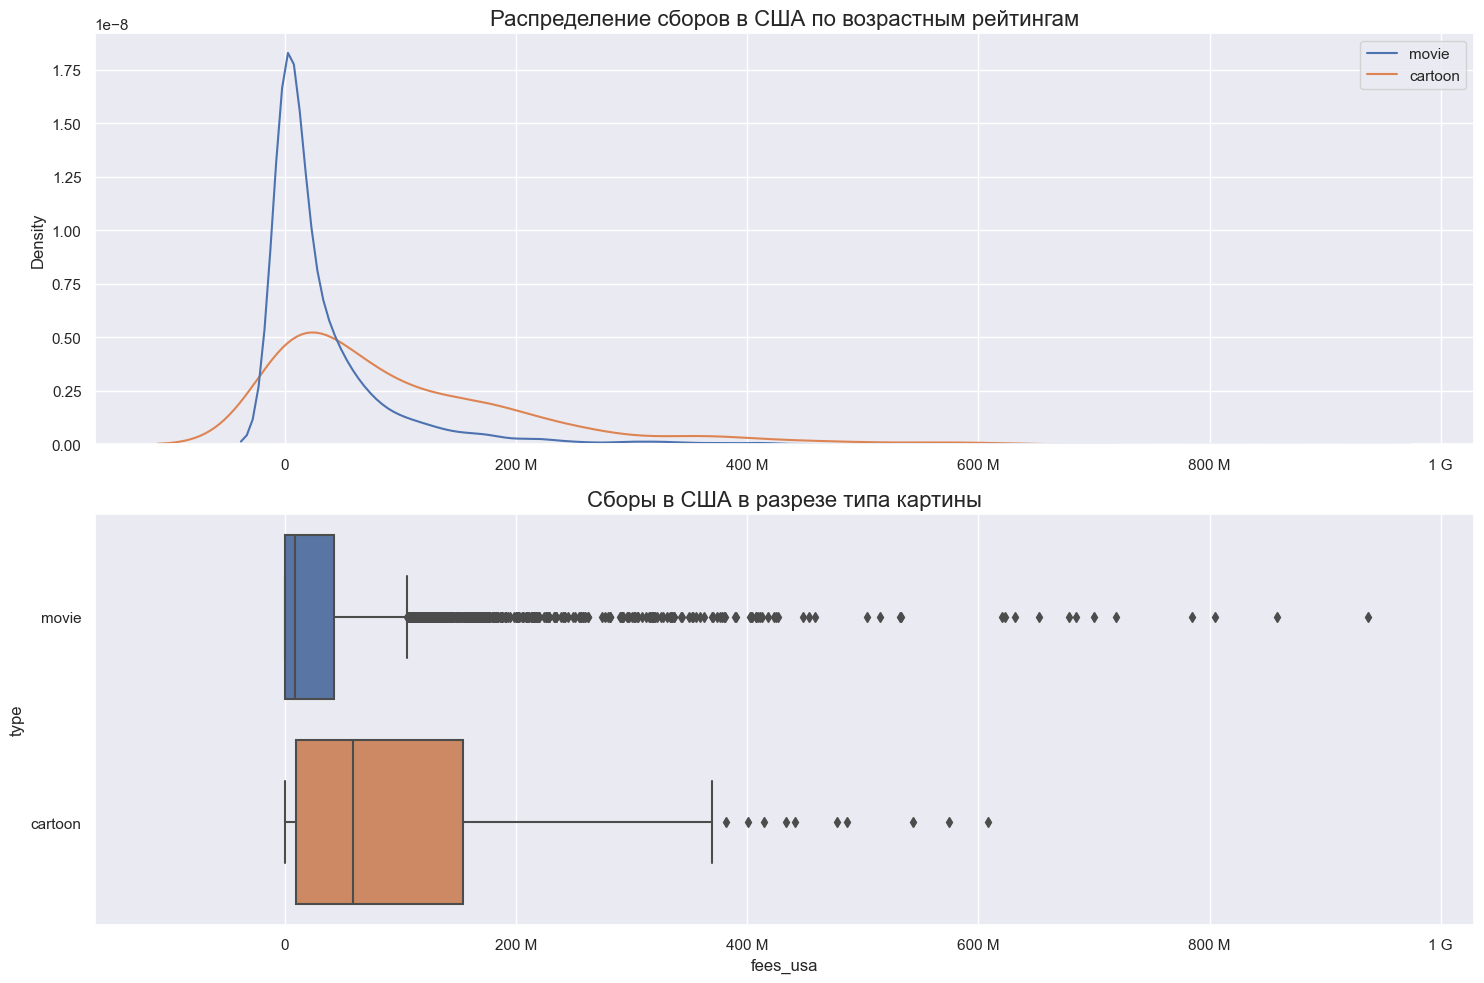

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# KDE plot
sns.kdeplot(
    data={
        "movie": df[df.type =='movie'].fees_usa,
        "cartoon": df[df.type =='cartoon'].fees_usa,
    },
    common_norm=False,
    ax=axes[0])
    
axes[0].xaxis.set_major_formatter(eng_format)
axes[0].set_title(
    'Распределение сборов в США по возрастным рейтингам', fontsize=16)

# Boxplot
sns.boxplot(data=df, y='type', x='fees_usa',
            orient='h', showfliers=True, ax=axes[1])

axes[1].xaxis.set_major_formatter(eng_format)
axes[1].set_title('Сборы в США в разрезе типа картины', fontsize=16)

xlimits = axes[0].get_xlim()  
axes[1].set_xlim(xlimits)    

plt.tight_layout()
plt.show()

**Выводы:**


**Для кинофильмов:** 
 - Медианный сбор составляет примерно 9 млн долларов. Половина всех кинофильмов собрала больше этой суммы.
 - Есть кинофильмы с выдающимися сборами, превышающими 100 млн долларов.


**Для мультфильмов:** 
- Медианный сбор составляет примерно 60 млн долларов, что значительно выше, чем для кинофильмов.
- Также есть мультфильмы с выдающимися сборами, превышающими 400 млн долларов.
- Несмотря на то что мультфильмов гораздо меньше, их медиана сборов выше. Это может указывать на то, что мультфильмы в целом более прибыльны, чем кинофильмы, или имеют большую аудиторию в США.

# Создание бинаризованных колонок

In [21]:
# Преобразуем колонки в тип список, чтобы создать dummies
for col in ['genres', 'countries', 'Производство', 'Спецэффекты']:
    
    df[col] = df[col].fillna('[]')
    df[col] = df[col].apply(lambda x: x
                            if isinstance(x, list) else ast.literal_eval(x))

In [22]:
def make_dummies(df, col):
    return df[col].str.join('|').str.get_dummies(sep='|')

# Создадим бинаризованные колонки для студий, жанров и стран
production_dummies = make_dummies(df, 'Производство')
effects_dummies = make_dummies(df, 'Спецэффекты')
countries_dummies = make_dummies(df, 'countries')
genres_dummies = make_dummies(df, 'genres')

In [23]:
print('Всего уникальных жанров в фильмах:', genres_dummies.shape[1])
print('Всего уникальных стран в фильмах:', countries_dummies.shape[1])
print('Всего уникальных студий производства:', production_dummies.shape[1])
print('Всего уникальных студий спецэффектов:', effects_dummies.shape[1])

Всего уникальных жанров в фильмах: 27
Всего уникальных стран в фильмах: 89
Всего уникальных студий производства: 8627
Всего уникальных студий спецэффектов: 2221


In [24]:
# Посмотрим на частоту жанров фильмов
counts = genres_dummies.sum()
sorted_counts = counts.sort_values(ascending=False)
sorted_counts

драма              2994
комедия            1919
триллер            1512
боевик             1265
мелодрама          1242
криминал           1005
приключения         916
фэнтези             681
ужасы               646
фантастика          643
детектив            581
семейный            528
биография           461
мультфильм          292
история             292
военный             232
музыка              199
спорт               171
документальный      107
мюзикл              106
вестерн              60
концерт               5
детский               3
новости               1
короткометражка       1
для взрослых          1
фильм-нуар            1
dtype: int64

In [25]:
# Выберем жанры вручную - оставим все до вестерна (включительно)
genres_filtered = genres_dummies[sorted_counts.loc[:'вестерн'].index.values]

In [26]:
# Для остальных групп колонок установим порог дисперсии
# Оставим студии и страны, которые встречаются минимум в 2% фильмов

def filter_dummies(dummies: pd.DataFrame, p: float) -> pd.DataFrame:
    """
    Фильтрует столбцы в dummy-датафрейме на основе порога дисперсии.
    
    Параметры:
    - dummies (DataFrame): Исходный датафрейм с dummy-переменными.
    - p (float): Пороговое значение для доли единиц в столбце.

    Возвращает:
    - DataFrame: Отфильтрованный датафрейм с dummy-переменными,
        удовлетворяющими условию дисперсии.
    """
    
    # Дисперсия = p(1-p), где p - доля единиц
    # Для p=0.02 будет дисперсия для признака с 2% единиц
    threshold = p * (1 - p)

    selector = VarianceThreshold(threshold=threshold)
    selector.fit(dummies)
    
    return dummies[dummies.columns[selector.get_support(indices=True)]]

In [27]:
p = 0.02
countries_filtered = filter_dummies(countries_dummies, p)
effects_filtered = filter_dummies(effects_dummies, p)
production_filtered = filter_dummies(production_dummies, p)

print(f'Порог дисперсии {p*100:.1f}%')
print('Всего уникальных стран в фильмах:', countries_filtered.shape[1])
print('Всего уникальных студий производства:', production_filtered.shape[1])
print('Всего уникальных студий спецэффектов:', effects_filtered.shape[1])

Порог дисперсии 2.0%
Всего уникальных стран в фильмах: 12
Всего уникальных студий производства: 14
Всего уникальных студий спецэффектов: 16


In [28]:
# Переименуем длинные названия студий, для удобного представления на графике

effects_filtered = effects_filtered.rename(columns={
    'Industrial Light & Magic (ILM)': 'ILM',
    'Moving Picture Company, The': 'MPC',
    'Gentle Giant Studios Inc.': 'GGS',
    'Pacific Title & Art Studio': 'PT & Art Studio',
    'Pacific Title': 'PT'
})

production_filtered = production_filtered.rename(columns={
    '20th Century Fox Film Corporation': '20th Century Fox Film Corp.',
    'Canal+\xa0[fr]': 'Canal+[fr]',
    'Centre National de la Cinématographie (CNC)': 'CNC',
    'Columbia Pictures Corporation': 'Columbia Pictures Corp.'
})

In [29]:
# Присоединим бинаризованные колонки к временному датасету - для графиков
df_temp = pd.concat([
    df[['fees_usa']], genres_filtered, countries_filtered, effects_filtered,
    production_filtered
], axis=1)

# Гипотеза (жанры, студии и сборы)

Фильмы с популярными жанрами и студиями собирают больше денег.

In [30]:
def plot_fees_dummies(dummies: pd.DataFrame, 
                      df: pd.DataFrame, 
                      title_barplot: str, 
                      title_box: str) -> None:
    """
    Рисует два графика: barplot и boxplot. 
    Barplot отображает распределение категориальных данных из `dummies`.
    Boxplot показывает распределение сборов фильмов для каждой категории.

    Parameters:
    - dummies (pd.DataFrame): DataFrame, содержащий dummy-переменные 
    - df (pd.DataFrame): Исходный DataFrame, содержащий столбец `fees_usa` со сборами фильмов.
    - title_barplot (str): Заголовок для верхнего графика (barplot).
    - title_box (str): Заголовок для нижнего графика (boxplot).

    Returns:
    - None: Функция отображает графики и ничего не возвращает.
    """

    # Сортировка dummy-переменных по количеству ненулевых значений
    sorted_counts = dummies.sum().sort_values(ascending=False)
    
    # Создание фигуры и осей для двух графиков
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 14))

    # Построение верхнего графика (barplot)
    sns.barplot(x=sorted_counts.index, y=sorted_counts.values, palette='turbo', ax=axes[0])
    axes[0].set_xticklabels(sorted_counts.index, rotation=90)
    axes[0].set_ylabel('Количество фильмов', fontsize=14)
    axes[0].set_title(title_barplot, fontsize=16)

    # Сбор данных для boxplot
    data = {}
    for col in sorted_counts.index:
        data[col] = df[df[col]==1].fees_usa

    # Построение нижнего графика (boxplot)
    sns.boxplot(data=pd.DataFrame(data), showfliers=True, palette='turbo', ax=axes[1])
    axes[1].xaxis.set_major_formatter(eng_format)
    axes[1].set_xticklabels(sorted_counts.index, rotation=90)
    axes[1].set_ylabel('Сборы', fontsize=14)
    axes[1].set_title(title_box, fontsize=16)

    # Настройка формата осей
    axes[0].yaxis.set_major_formatter(eng_format)
    axes[1].yaxis.set_major_formatter(eng_format)

    # Улучшение внешнего вида графиков
    plt.tight_layout()
    plt.show()

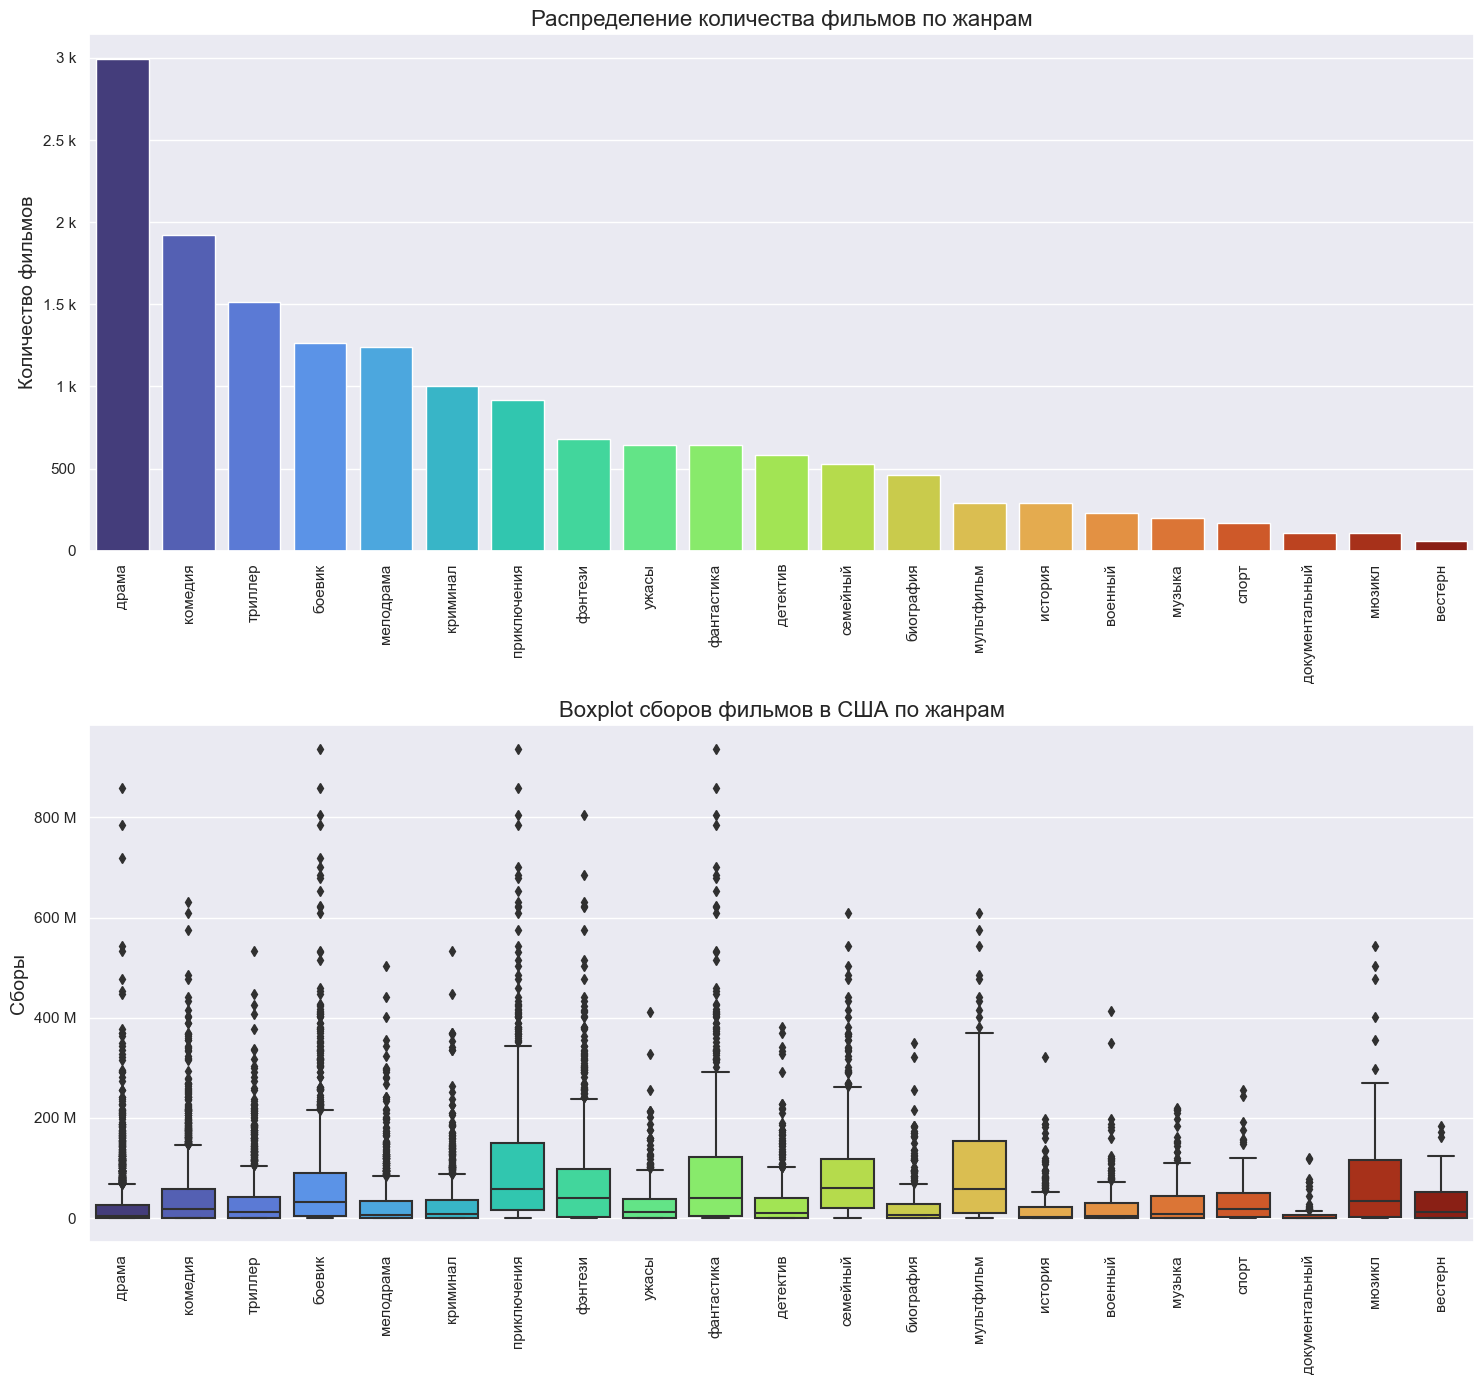

In [31]:
plot_fees_dummies(genres_filtered, df_temp,
                  'Распределение количества фильмов по жанрам',
                  'Boxplot сборов фильмов в США по жанрам')

**<big>Жанры. Выводы:**

- **Сборы в зависимости от жанра:**
    - **Драма:** 
    <br>Самый популярный жанр, медианные сборы находятся на среднем уровне по сравнению с другими жанрами. 
    <br>Однако есть выбросы в верхней части диапазона - есть драмы, которые стали кассовыми хитами.
    - **Комедия:** 
    <br>Cхожая с "драмой" тенденция:
    <br>Второй по популярности жанр, медианные сборы невелики, но существует много выбросов в верхнем диапазоне.
    - **Приключения:** 
    <br>Жанр менее популярен, но его медианные сборы весьма высоки. В этом жанре в среднем собирают больше денег.
    - **Фантастика и мультфильм:** 
    <br>Не являются самыми популярными, но имеют относительно высокие медианные сборы и множество выбросов в верхнем диапазоне.


- **Выбросы:** 
<br>Наличие высоких выбросов для многих жанров указывает на то, что, хотя большинство фильмов в этих жанрах может не достигать выдающихся сборов, есть исключения, которые становятся кассовыми хитами.


**Общий вывод:** 

Наличие или отсутствие корреляции между популярностью жанра и сборами зависит от того, как мы определяем "успех". <br><br>Некоторые менее популярные жанры, такие как "приключения" или "фантастика", в среднем собирают больше денег. 
<br>Однако популярные жанры, такие как "драма" и "комедия", имеют большое количество фильмов, которые становятся кассовыми хитами, даже если медианные сборы для этих жанров невысоки.
<br><br>Популярность жанра сама по себе не гарантирует высоких сборов, но она может увеличивать шансы фильма стать кассовым хитом.

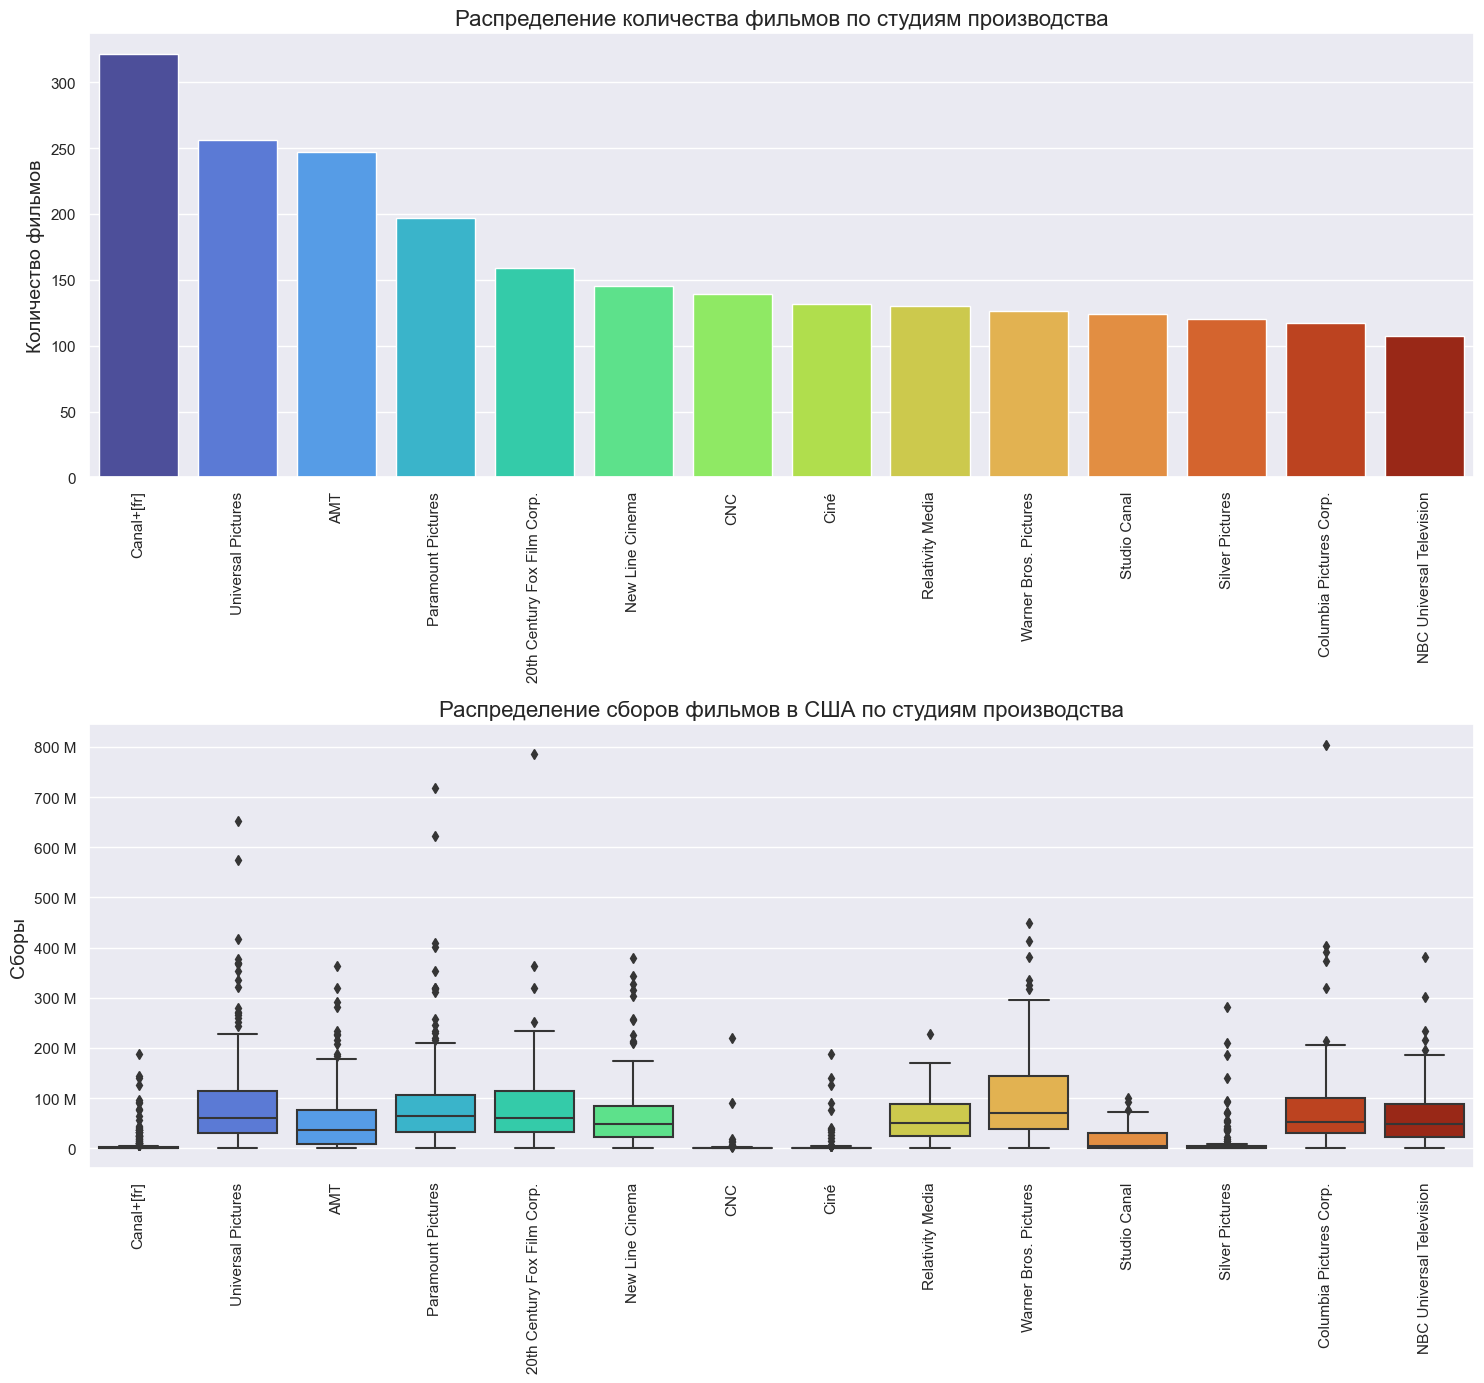

In [32]:
plot_fees_dummies(production_filtered, df_temp,
                  'Распределение количества фильмов по студиям производства',
                  'Распределение сборов фильмов в США по студиям производства')

**<big>Студии производства. Выводы:**

- **Популярность студии (основываясь на количестве выпущенных фильмов) не обязательно гарантирует высокие сборы**. 
<br>Например, Canal+[fr] выпустила более 300 фильмов, но их медианные сборы невысоки. 
<br>В то время как Universal Pictures, выпустив около 250 фильмов, имеет гораздо более высокие медианные сборы.



- **Многие крупные студии имеют фильмы-выбросы, которые собрали огромные суммы денег**. 
<br>Это может указывать на то, что у этих студий есть потенциал создавать кассовые хиты, даже если их обычные фильмы собирают средние или ниже среднего сборы.


- **Наличие высоких выбросов может также указывать на неравномерное распределение бюджетов на производство фильмов**. 
<br>Некоторые фильмы могут получать значительно больше инвестиций, чем другие, что может привести к более высоким сборам.


- **Наивысшие сборы далеко не всегда связаны со студиями производства с наибольшим количеством фильмов**. 
<br>Это может указывать на то, что качество, маркетинг, актерский состав и другие факторы играют ключевую роль в коммерческом успехе фильма, а не только бренд студии.

**Общий вывод:** 

Хотя популярные студии производства часто имеют хорошие сборы благодаря своей репутации и ресурсам, качество и маркетинг фильма, а также другие факторы, по-прежнему имеют решающее значение для его коммерческого успеха.

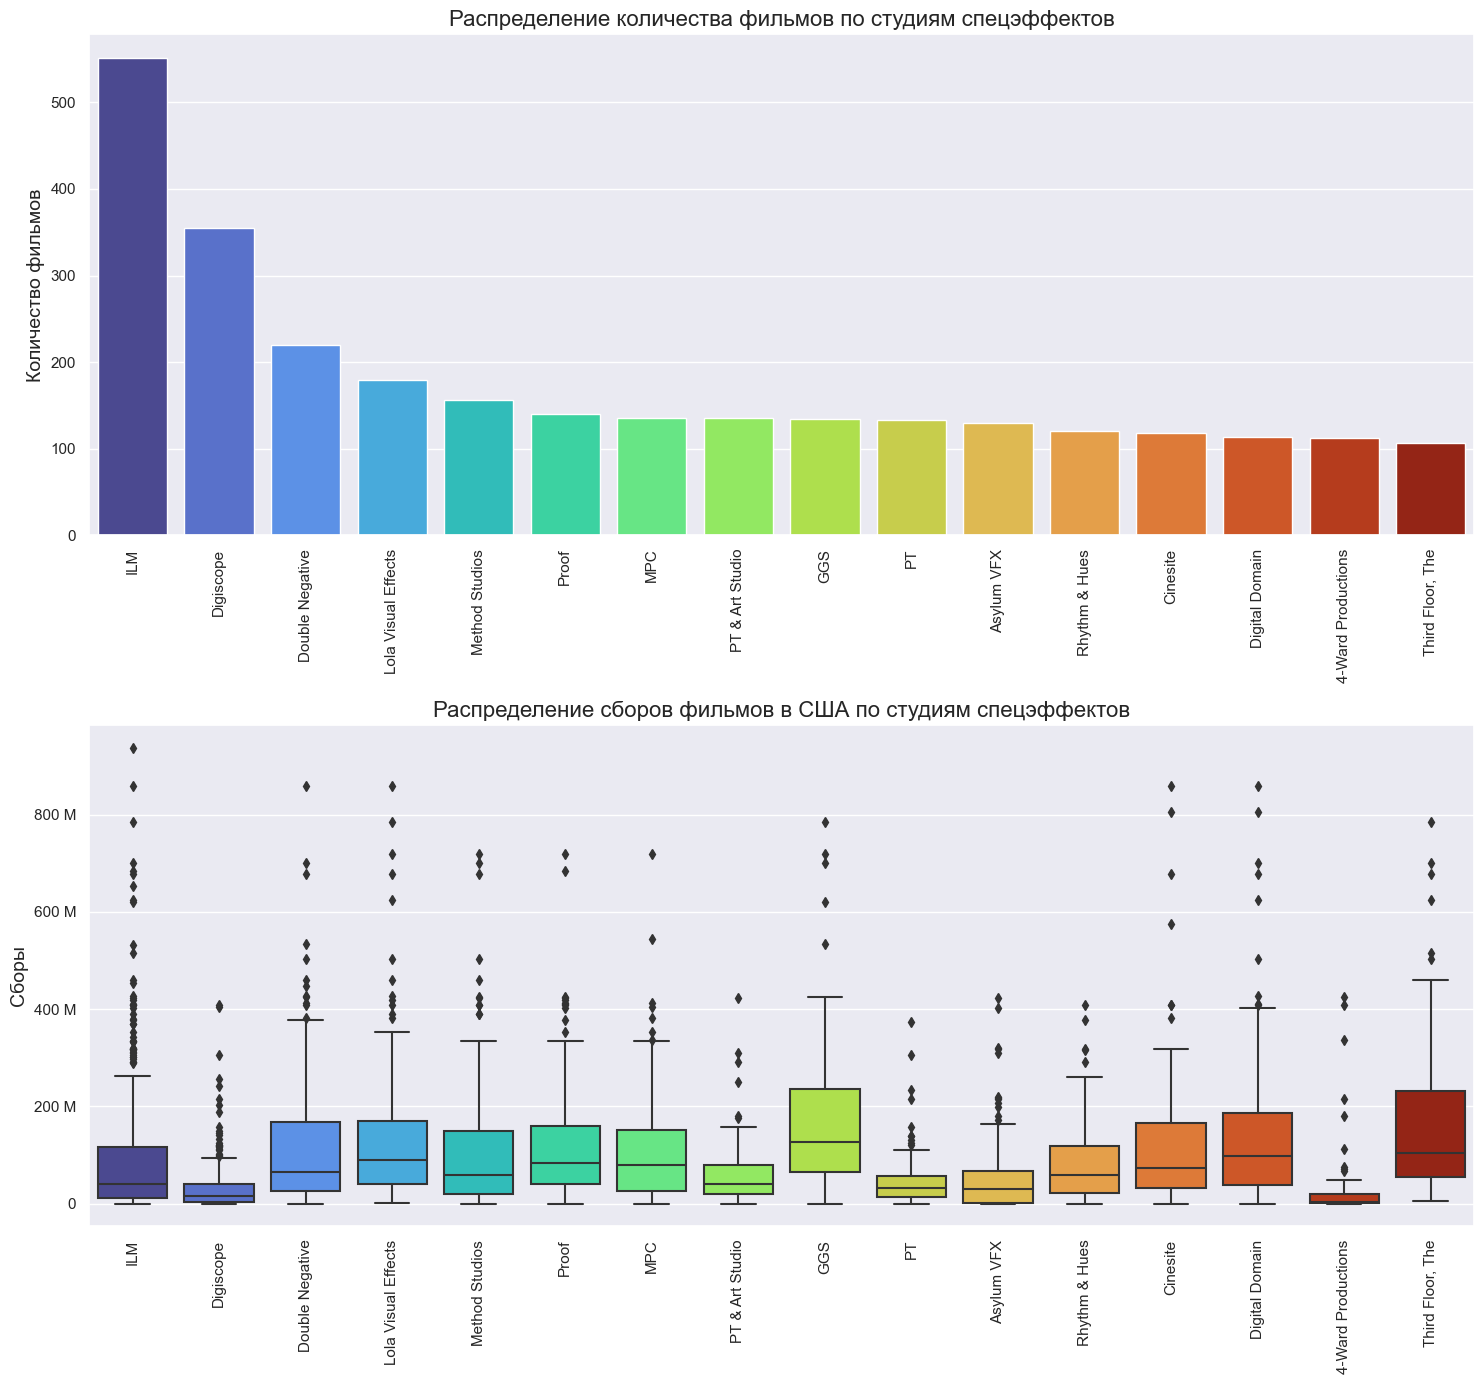

In [33]:
plot_fees_dummies(effects_filtered, df_temp,
                  'Распределение количества фильмов по студиям спецэффектов',
                  'Распределение сборов фильмов в США по студиям спецэффектов')

**<big>Студии спецэффетктов. Выводы:**

- **ILM (Industrial Light & Magic)** 
    <br> Несмотря на их огромное количество проектов, демонстрируют, что их опыт и масштаб действительно влияют на высокие сборы.
    
    
- **Digiscope** 
    <br>Имеет много проектов, но их сборы относительно скромные по сравнению с другими лидерами.

    
- **Double Negative**, 
- **Lola Visual Effects**
- **Method Studios**
    <br>Являются выдающимися студиями спецэффектов, если судить по соотношению их сборов к количеству проектов. <br>Они имеют меньше проектов по сравнению с ILM, но сборы с их фильмов чрезвычайно высоки.

    
- **MPC** (Moving Picture Company, The)
- **GGS** (Gentle Giant Studios Inc.)
- **Proof**
<br>Также отличаются высокими показателями сборов для своих проектов, что делает их одними из главных игроков в индустрии спецэффектов.
    

- **Asylum VFX**, 
- **Rhythm & Hues**, 
- **Cinesite**, 
- **Digital Domain**
- **Third Floor, The**
<br>Являются другими заметными студиями, которые имеют фильмы с очень высокими кассовыми сборами.


**Общий вывод:**

Можно заключить, что студии спецэффектов играют большую роль в успешности многих кассовых фильмов. 
<br>Высокое качество их работы часто коррелирует с высокими сборами фильма.

# Анализ распределений и линейных зависимотей

In [34]:
features = [
 'year',
 'votes_kp',
 'votes_imdb',
 'votes_filmCritics',
 'votes_await',
 'rating_kp',
 'rating_imdb',
 'rating_filmCritics',
 'movieLength',
 'ageRating',
 'fees_world',
 'fees_usa',
 'fees_russia',
 'budget_in_usd',
 'videos_trailers_number'
]

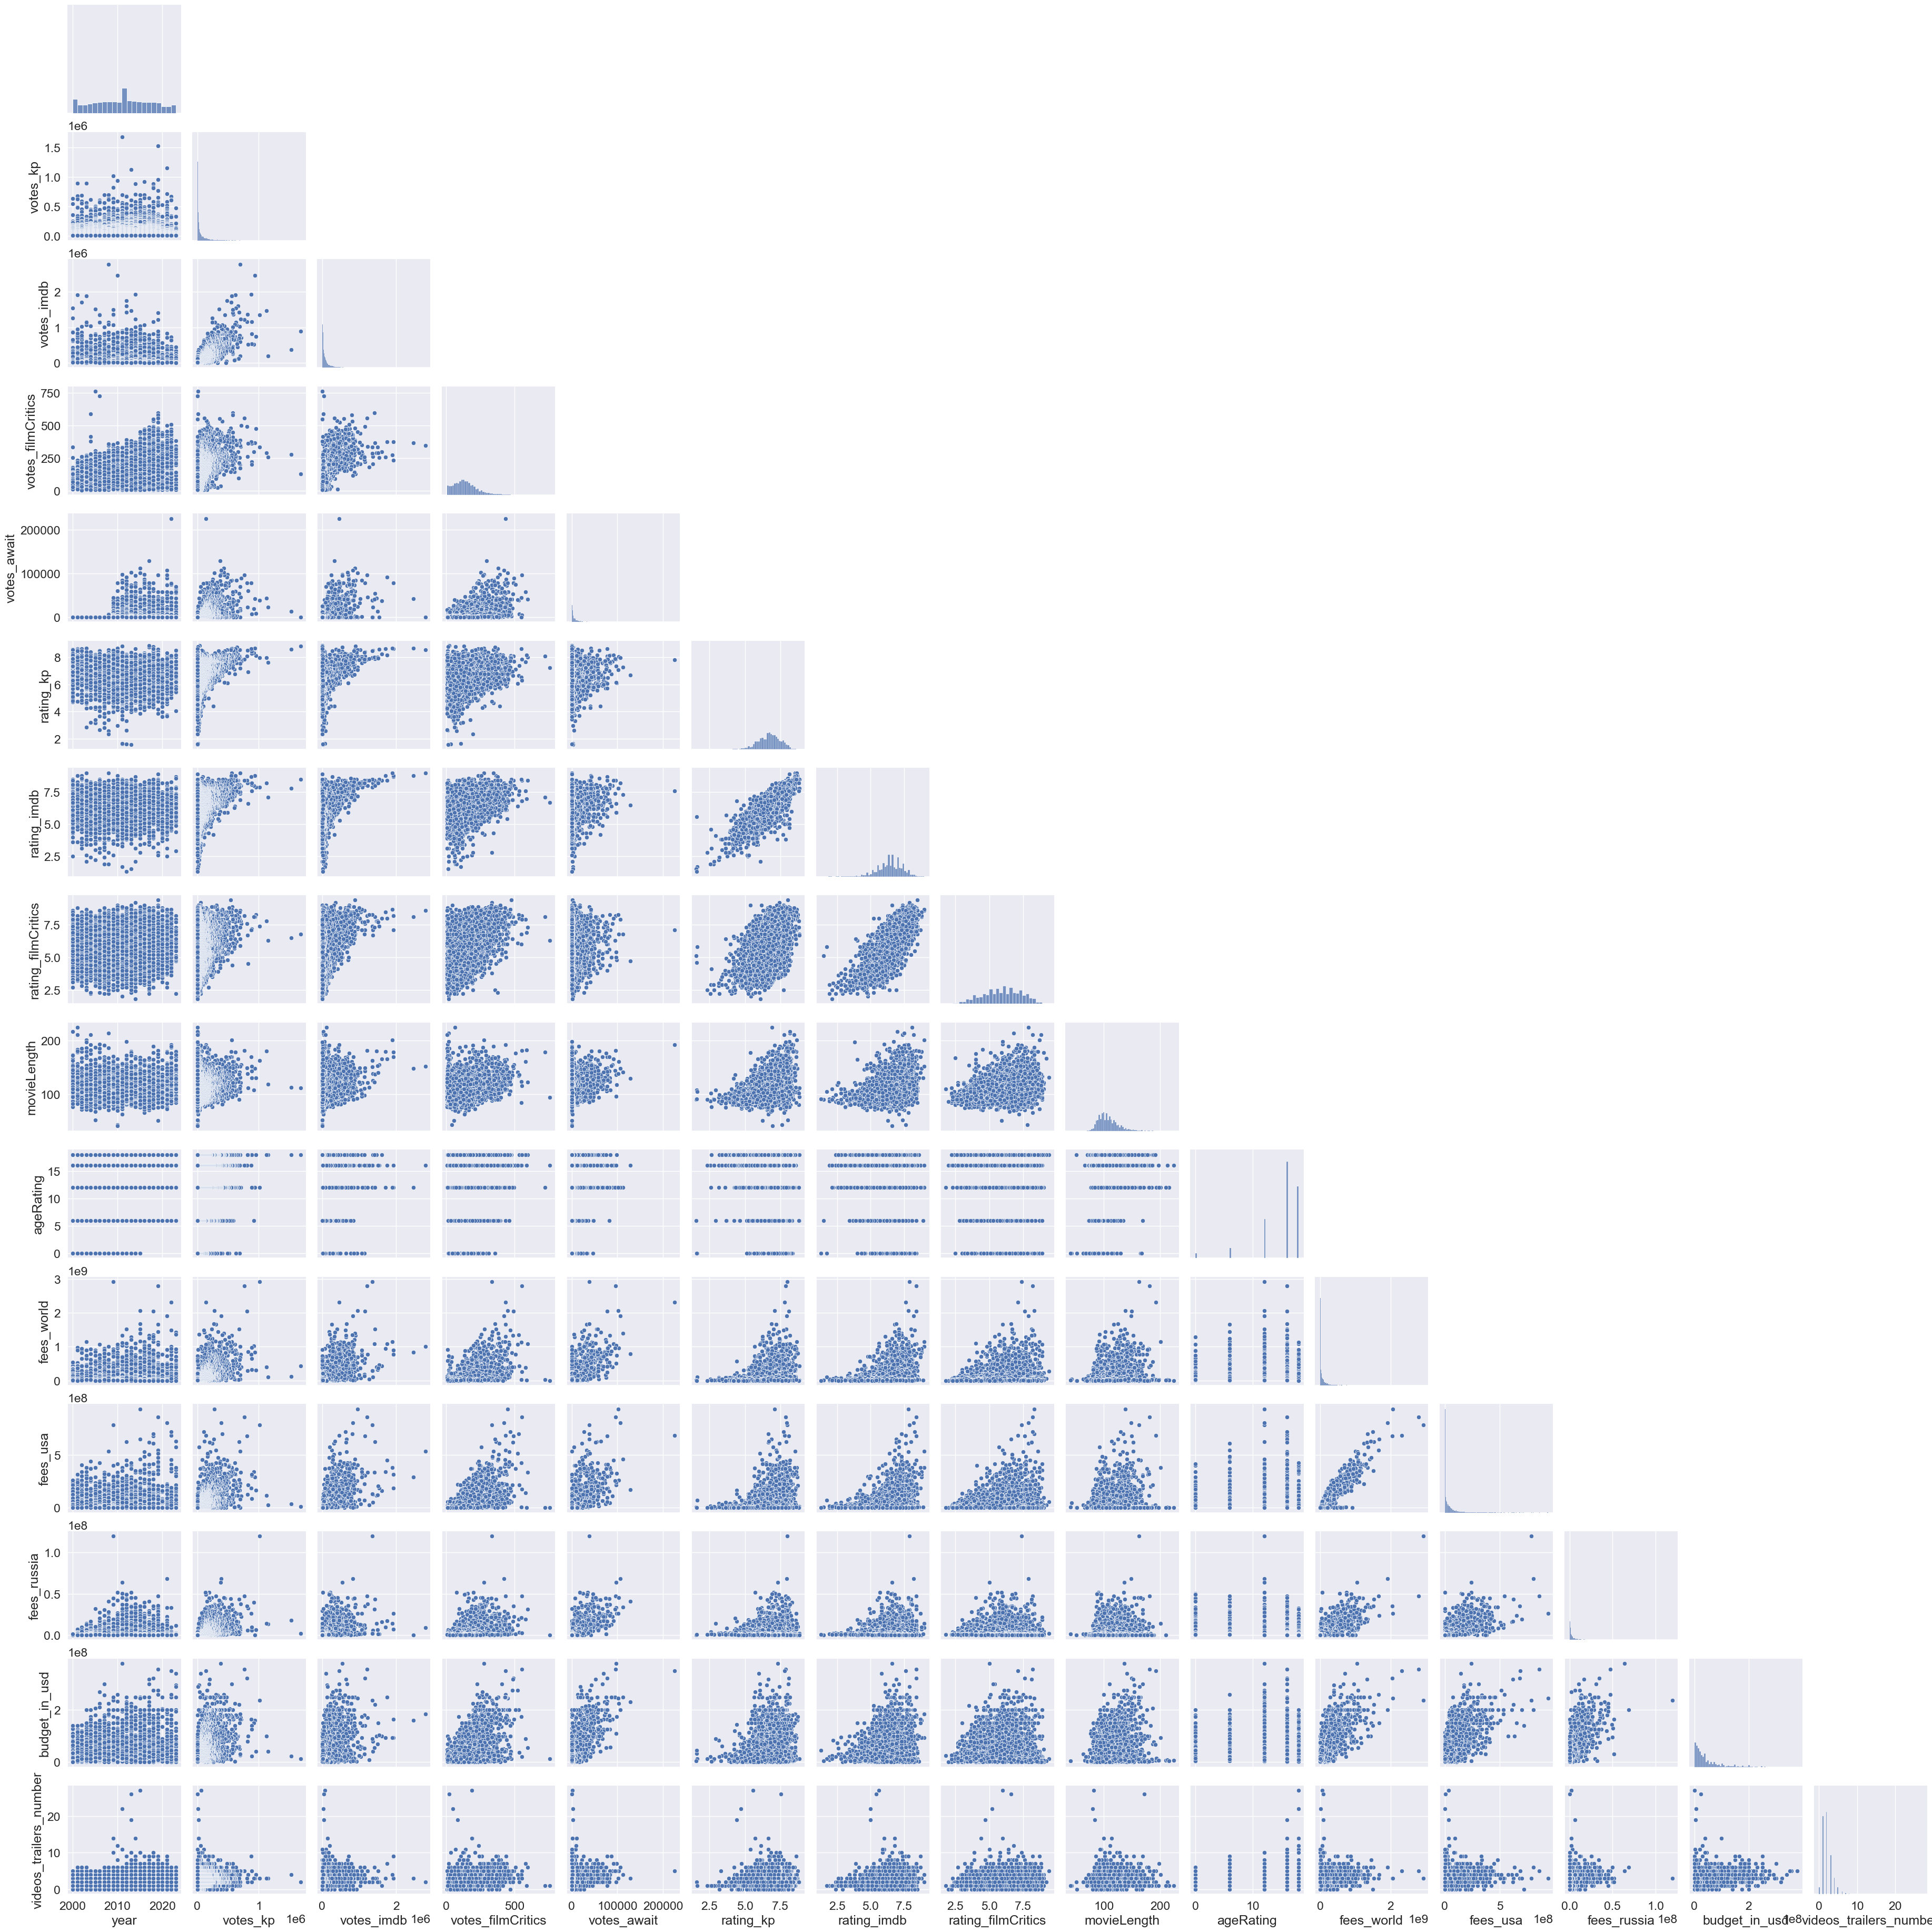

In [35]:
sns.set(font_scale=1.5)  # увеличивает размер шрифта на 1.5 раза
sns.pairplot(df[features], corner=True, height=2.5)

plt.show();

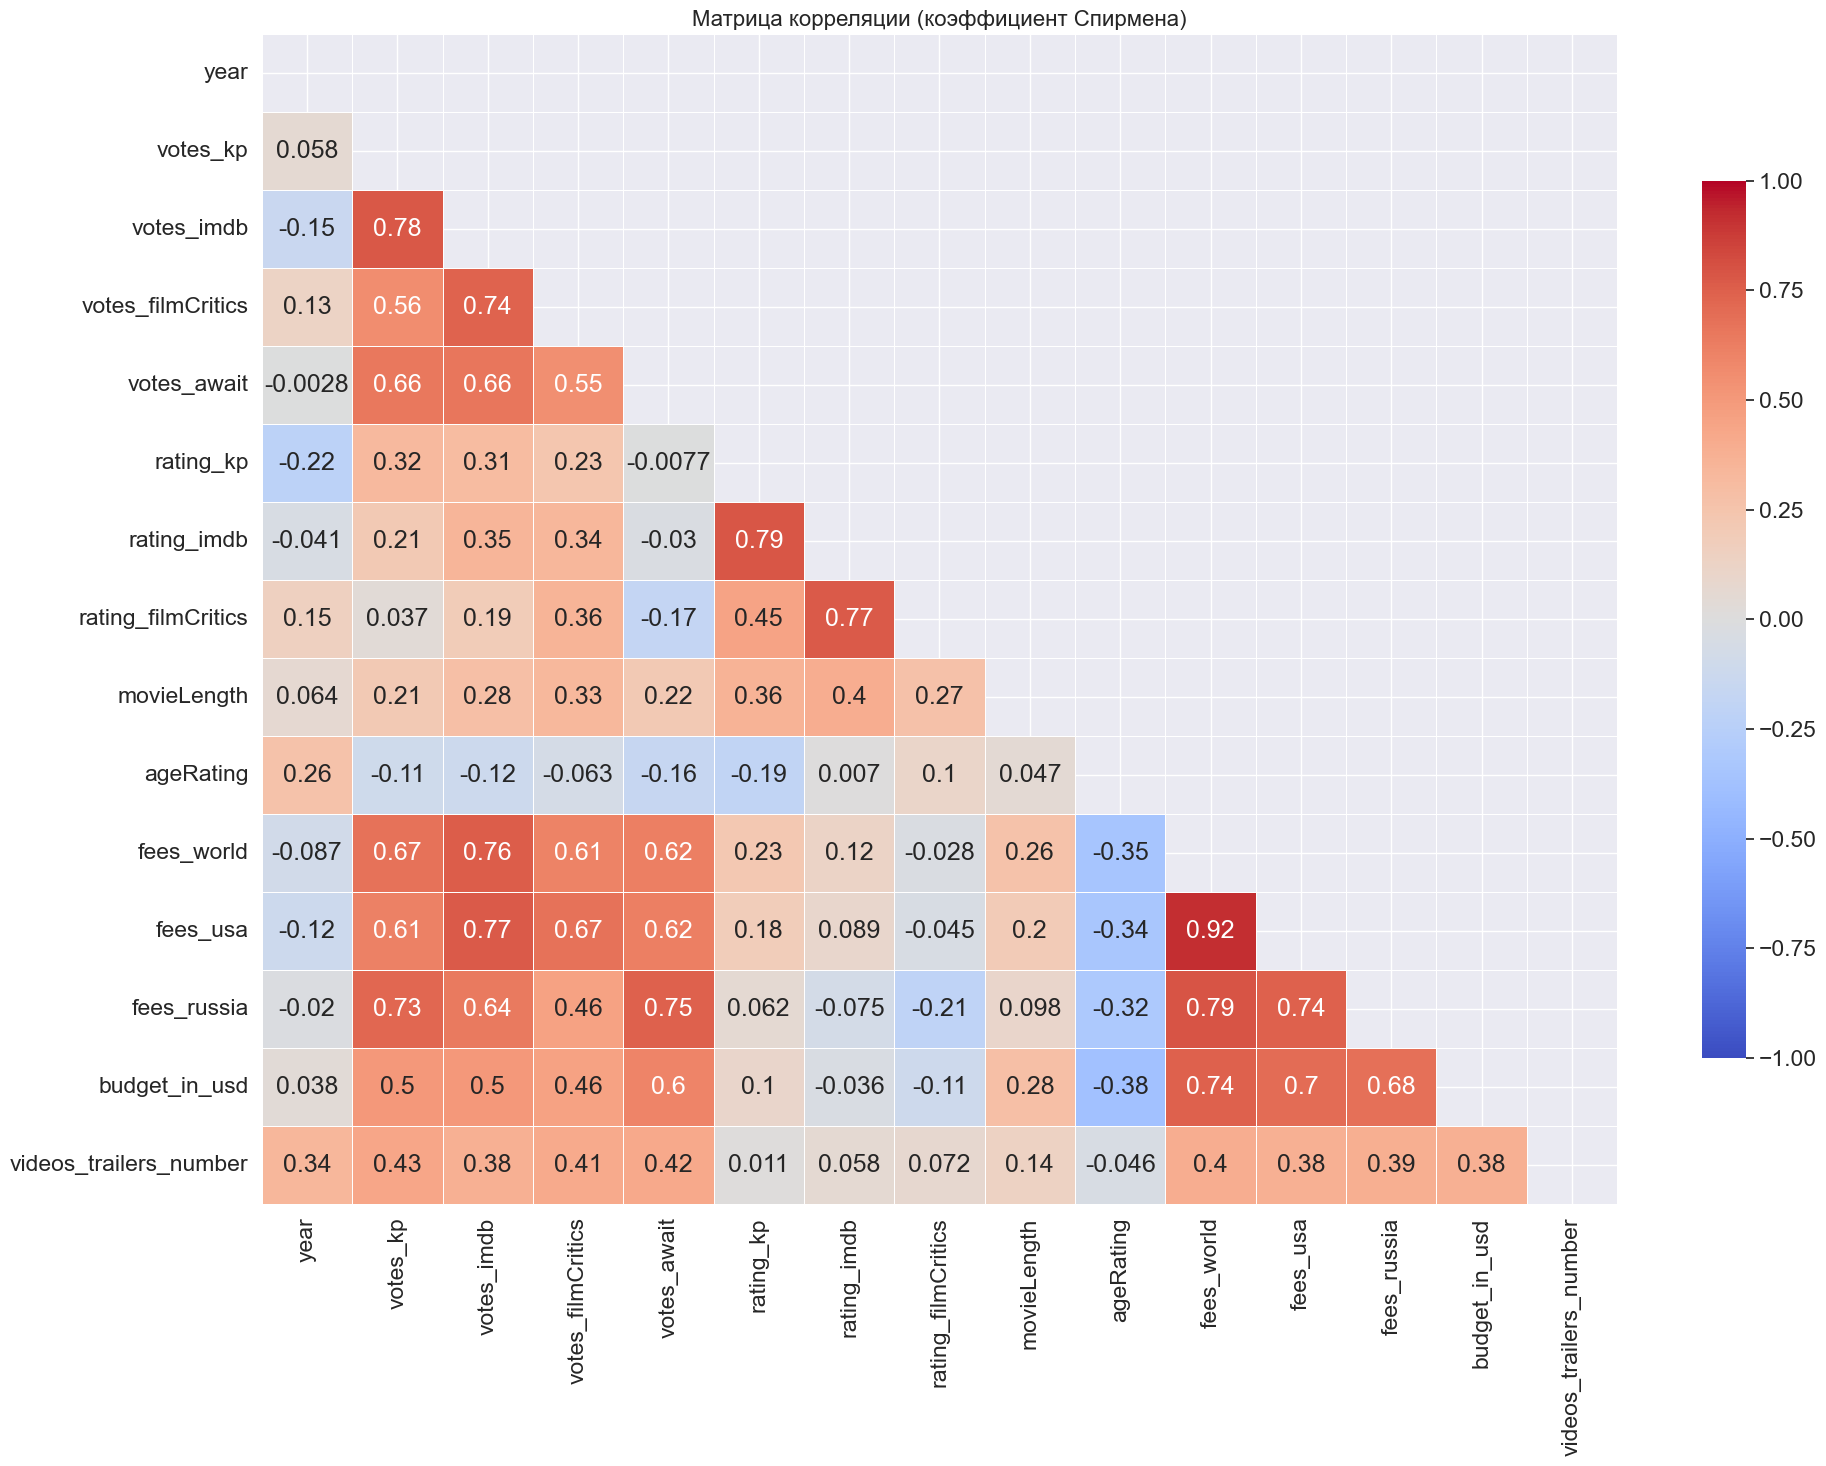

In [36]:
# Вычисляем корреляционную матрицу
corr = df[features].corr(method='spearman', numeric_only=True)

# Получаем верхний треугольник матрицы
mask = np.triu(np.ones_like(corr, dtype=bool))

# Создаем фигуру и оси
plt.figure(figsize=(20, 15))

sns.set(font_scale=1.5)  # увеличивает размер шрифта на 1.5 раза

# Создаем heatmap
sns.heatmap(
    corr, 
    annot=True,      # Аннотация значений
    mask=mask,       # Маска, чтобы показать только нижний треугольник
    cmap='coolwarm', # Цветовая палитра
    vmin=-1, vmax=1, # Минимальное и максимальное значение для масштабирования цветов
    linewidths=.5,   # Ширина линий между квадратами
    cbar_kws={"shrink": 0.75}  # Уменьшение размера цветовой шкалы
)

plt.title("Матрица корреляции (коэффициент Спирмена)", fontsize=16)
plt.tight_layout()
plt.show()

1. **Сильная связь**:
   - **Количество оценок на Кинопоиске и IMDb**: фильмы, высоко оцененные на одной платформе, обычно высоко оценены и на другой.
   - **Рейтинги на Кинопоиске и IMDb**: согласованность оценок между двумя платформами.
   - **Количество оценок и сборы**: популярные фильмы на Кинопоиске и IMDb имеют высокие сборы в мире, США и России.
   - **Сборы мировые и в США/России**: успешные фильмы в мире также популярны в США и России.


3. **Отрицательная связь**:
   - **Возрастной рейтинг и сборы**: фильмы с более высоким возрастным рейтингом зарабатывают меньше.
   - **Год выпуска и рейтинг на Кинопоиске**: старые фильмы могут иметь более высокий рейтинг.

Помимо этого, многие переменные имеют слабую или отсутствующую связь, что говорит об их независимости друг от друга.

In [39]:
# Сохраним измененный датасет для следующих ноутбуков
df.to_csv('data/movies_main_modified.csv', sep=';')